# Imports

In [1]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pylab import rcParams
import seaborn as sns
from array import array
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import linregress
from scipy.stats import mannwhitneyu
import statistics
%matplotlib inline


# Useful functions

In [2]:
begins=[]
ends=[]
names =[]
with open ("CommonData/sequence.gb") as f:
    in_pep = False
    for l in f:
        if "mat_peptide" in l:
            begins.append(int(l.split()[1].split("..")[0]))
            ends.append(int(l.split()[1].split("..")[1]))
            in_pep = True
        elif in_pep :
            names.append(l.split("=")[1])
            in_pep = False
            
print(begins)
print(ends)
print(names)

[108, 474, 753, 978, 2490, 3546, 4224, 4614, 6465, 6846, 6915, 7668]
[473, 752, 977, 2489, 3545, 4223, 4613, 6464, 6845, 6914, 7667, 10376]
['"capsid"\n', '"propeptide"\n', '"membrane"\n', '"envelope"\n', '"NS1"\n', '"NS2A"\n', '"NS2B"\n', '"NS3"\n', '"NS4A"\n', '"2K"\n', '"NS4B"\n', '"NS5"\n']


In [3]:
# Interesting positions
positions=[316,1670,1785,2340,5935,7172,8449,9165]
def plot_positions():
    for x in positions:
        plt.axvline(x=x, linewidth=1, linestyle=':')
        
def plot_genes():
    for i in range(len(begins)):
        plt.plot([begins[i], begins[i]], [0.99,1.0], linewidth=2, linestyle='-', color="black")
        if i%2==0:
            plt.text (begins[i] + ((ends[i] - begins[i])/10), 1.005, (names[i].replace('"', ''))[0:3], size='xx-small')
        else:
            plt.text (begins[i] + ((ends[i] - begins[i])/10), 1.015, (names[i].replace('"', ''))[0:3], size='xx-small')
    plt.plot([ends[-1], ends[-1]], [0.99,1.0], linewidth=2, linestyle='-', color="black")



In [4]:
def synonymous (row):
    if row['null'] or (row['Consensus_aa']==row['Secondbase_aa'] ):
        return "synonymous" 
    else:
        return "non-synonymous"

def add_columns(table):
    table['null'] = (table['Secondbase_aa']).isnull()
    table['is_synonymous'] = table.apply (lambda row: synonymous (row),axis=1)
    table['1_major_variant_frequency'] = 1.0 - table['Major_variant_frequency_quality_corrected']

In [5]:
def is_increasing(minor_frequencies):
    #print(minor_frequencies)
    tolerance = 0.01
    minimum_increase = 0.1
    previous = minor_frequencies[0]
    if minor_frequencies[-1] - minor_frequencies[0] < minimum_increase:
        return False
    for m in range(1,len(minor_frequencies)):
        if previous < minor_frequencies[m] or previous < minor_frequencies[m] + tolerance:
            #print(str(previous) + " < " + str(minor_frequencies[m]))
            previous = minor_frequencies[m]
        else:
            return False
    return True


# Strict definition of an increasing position
def is_strictly_increasing(minor_frequencies):
    #print(minor_frequencies)
    previous = minor_frequencies[0]
    for m in range(1,len(minor_frequencies)):
        if previous < minor_frequencies[m]:
            #print(str(previous) + " < " + str(minor_frequencies[m]))
            previous = minor_frequencies[m]
        else:
            return False
    return True


def get_variant_frequency(variant, table, i):
    sum_of_bases = table['As_quality_corrected'][i]+table['Cs_quality_corrected'][i]+table['Gs_quality_corrected'][i]+table['Ts_quality_corrected'][i]+table['Ns_quality_corrected'][i]
    if variant == "A":
        return table["As_quality_corrected"][i] / sum_of_bases
    elif variant == "C":
        return table["Cs_quality_corrected"][i] / sum_of_bases
    elif variant == "G":
        return table["Gs_quality_corrected"][i] / sum_of_bases
    elif variant == "T":
        return table["Ts_quality_corrected"][i] / sum_of_bases
    else:
        return np.nan
        

def get_increasing_variants(tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    increasingVariants = dict()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        if major == last["Major_variant"][i]:
            minor = last["Second_variant"][i]
        else:
            minor = last["Major_variant"][i]
        minor_frequencies[0] = get_variant_frequency(minor, first, i)
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
            minor_frequencies[table_id] = get_variant_frequency(minor, tables[table_id], i)
        if is_increasing(minor_frequencies):
            increasingVariants[i] = [major_frequencies.tolist(), minor_frequencies.tolist()]
    return increasingVariants


def printMajorFrequencyThroughSamples(tables, numPos):
    major = tables[0]['Major_variant'][numPos]
    last_major = tables[0]['Major_variant'][numPos]
    print("Position "+ str(numPos) +", Major variant in first sample: " + major)
    print("Position "+ str(numPos) +", Frequencies of "+major+" through the samples: ")
    for i in range(len(tables)):
        print("\t"+str(get_variant_frequency(major, tables[i], numPos)))
    print("Position "+ str(numPos) +", Major variant in last sample: " + tables[-1]['Major_variant'][numPos])

    
def printMajorFrequencyThroughSamples_2340_7172(tables):
    printMajorFrequencyThroughSamples(tables, 2340)
    printMajorFrequencyThroughSamples(tables, 7172)

In [6]:
# Functions to think in terms of standard deviation of the frequency per site
def get_varying_variants(tables):
    sd_threshold = 0.1
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    minor_frequencies = array('d',[0.0]*num_tables)
    varyingVariants = dict()
    for i in first["Position"]:
        major = first["Major_variant"][i]
        #print(last['Major_variant_frequency_quality_corrected'][i])
        major_frequencies[0] = first['Major_variant_frequency_quality_corrected'][i]
        for table_id in range(1, num_tables):
            major_frequencies[table_id] = get_variant_frequency(major, tables[table_id], i)
        sd_value = statistics.pstdev(major_frequencies)
        if sd_value > sd_threshold:
            varyingVariants[i] = sd_value
    print("There are "+str(len(varyingVariants))+" positions whose major variant varies a lot in frequency.")
    print("Those are:")
    print(varyingVariants.keys())
    return varyingVariants


# Reading the data

In [7]:
# Cirseq and clones
cirseq = pd.read_csv ("PKG-DREUX_HV5GLBCXY/CutAdaptPearViroMapperMapped/HV5GLBCXY_ZIKV_17s006139-1-1_DREUX_lane1CirseqD3_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(cirseq)
clone_12 = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1cloneD12_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(clone_12)
clone_15 = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1cloneD15_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(clone_15)
clone_19 = pd.read_csv ("HJJ7JBCX2_ZIKV/Mapped_Reads/HJJ7JBCX2_ZIKV-s-and-c_18s004258-1-1_DREUX_lane1cloneD19_1_sequence.txt.assembled.fastq_mapped_AA.csv", na_values=" -nan")
add_columns(clone_19)

tables_clone = [cirseq, clone_12, clone_15, clone_19]


In [8]:
# All tables
all_table_names = ["cirseq", "clone_12", "clone_15", "clone_19"]

# Analysis of coverage

In [9]:
def plotCoverage(tables, names):
    variable = 'Coverage'
    sample = list()
    posList = list()
    variableList = list()
    for i in range(len(names)):
        sample = sample + len(tables[i][variable]) * [names[i]]
        posList.append(tables[i]['Position'])
        variableList.append(tables[i][variable])
    positions = pd.concat(posList)
    variableValues = pd.concat(variableList)
    overlay_table_concat = pd.DataFrame ({'Position':positions, variable:variableValues, 'sample':sample})
    sns.lmplot( x="Position", y=variable, data=overlay_table_concat, fit_reg=False, hue='sample', legend=False, size=7, aspect=2, lowess=True,scatter_kws={"s": 20})
    plt.legend(loc='lower right')
    plot_positions()
    plot_genes()

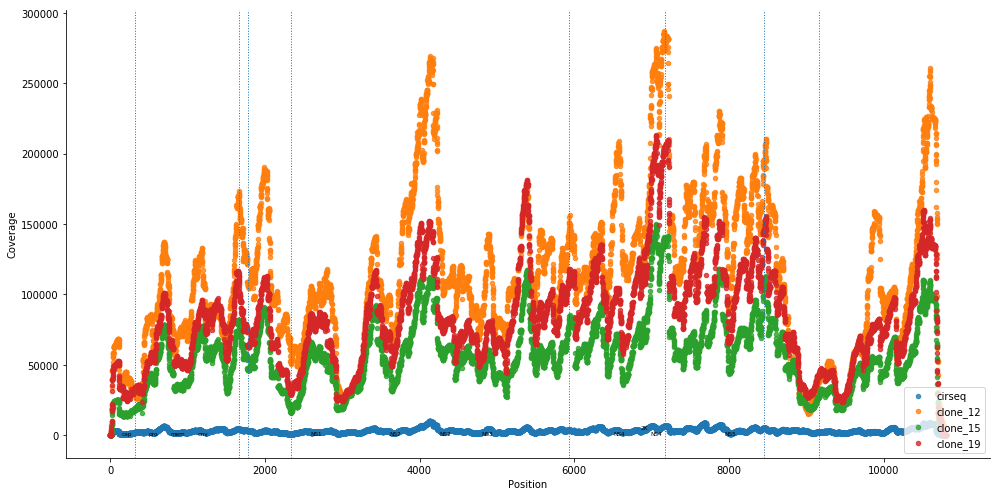

In [11]:
plotCoverage(tables_clone, all_table_names)

# Diversity plot

/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


(0, 1.2)

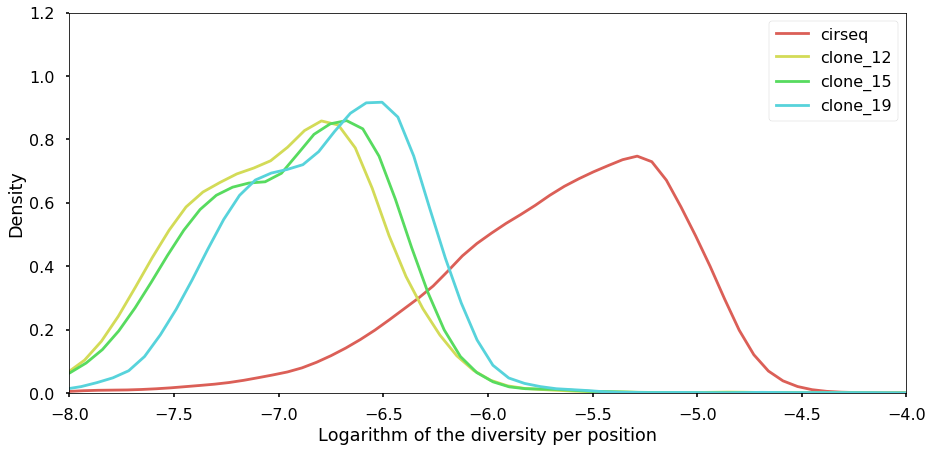

In [28]:
f, ax = plt.subplots(figsize=(15, 7))
lm=sns.kdeplot(np.log(tables_clone[0]["1_major_variant_frequency"]), label="cirseq")
lm.set_ylabel('Density')
lm.set_xlabel('Logarithm of the diversity per position')

lm=sns.kdeplot(np.log(tables_clone[1]["1_major_variant_frequency"]), label="clone_12")
lm=sns.kdeplot(np.log(tables_clone[2]["1_major_variant_frequency"]), label="clone_15")
lm=sns.kdeplot(np.log(tables_clone[3]["1_major_variant_frequency"]), label="clone_19")

axes = lm.axes
axes.set_xlim(-8,-4)
axes.set_ylim(0,1.2)

# Positions that increase in frequency in the different replicates and conditions

In [12]:
increasing = get_increasing_variants(tables_clone)
print("There are "+str(len(increasing))+" positions that rise in frequency.")
print("Those are:")
print(increasing.keys())

There are 40 positions that rise in frequency.
Those are:
dict_keys([253, 322, 418, 731, 1043, 1312, 1474, 1903, 2340, 2455, 2783, 2852, 2903, 3565, 3592, 4192, 4201, 4552, 5125, 5155, 5230, 5314, 5675, 6334, 6628, 6670, 6991, 7093, 7228, 7441, 7636, 8093, 8410, 8776, 9025, 9241, 9295, 9556, 9736, 9952])


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


## Plotting only positions that consistently rise in frequency

In [13]:
def plot_increasing_positions(increasing_pos, last_time_point) :
    sns.set_palette("hls")
    sns.set_context("poster")
    increasing_pos_keys = increasing_pos.keys()
    Is_increasing = []
    for i in last_time_point['Position']:
        if i in increasing_pos_keys:
            Is_increasing.append("Increasing")
        else:
            Is_increasing.append("Not increasing")
        
    to_plot = pd.DataFrame ({'Position':last_time_point['Position'], 'Major_variant_frequency_quality_corrected':last_time_point ['Major_variant_frequency_quality_corrected'],'Is_increasing':Is_increasing, 'is_synonymous':last_time_point ['is_synonymous']}) 
    ax=sns.lmplot( x="Position", y="Major_variant_frequency_quality_corrected", data=to_plot, fit_reg=False, hue='Is_increasing', row='is_synonymous', legend=False, size=7, aspect=2)
    ax.set(xlabel='Position along the genome', ylabel='Major variant frequency, last time point')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plot_positions()


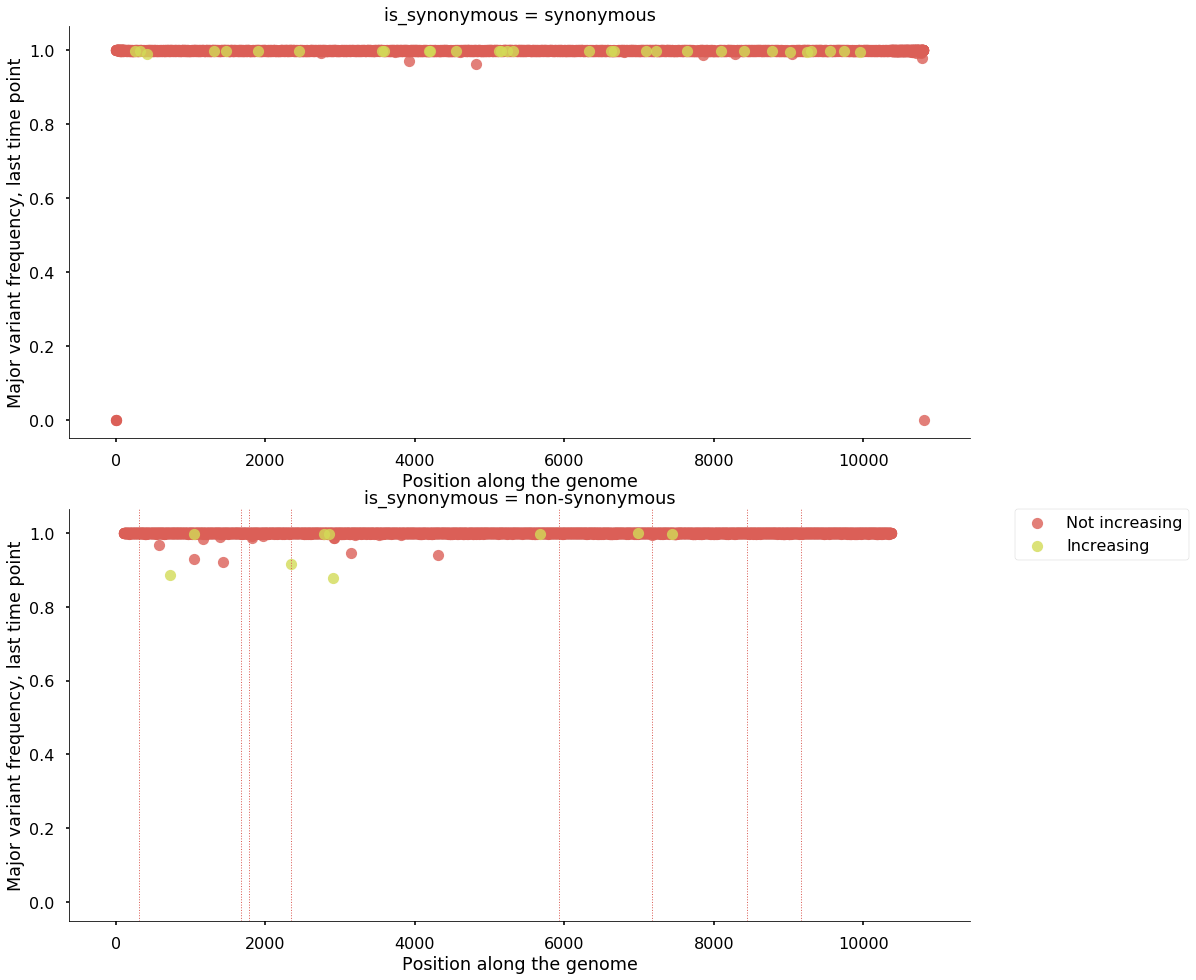

In [14]:
plot_increasing_positions(increasing, clone_19)

## Write out the table

In [15]:
def write_increasing_positions(increasing_pos, tables, exp_names, filename) :
    increasing_pos_table = pd.DataFrame()

    for d in tables:
        increasing_pos_table = pd.concat([increasing_pos_table,d[d['Position'].isin(increasing_pos)]])

    num = len(increasing_pos)

    expnames_iterated = []
    for i in exp_names : 
        expnames_iterated.append([i]*num)

    expnames = [item for sublist in expnames_iterated for item in sublist]
    print(len(expnames))
    increasing_pos_table['expName']=expnames
    increasing_pos_table.to_csv( filename )


In [16]:
write_increasing_positions(increasing, tables_clone, all_table_names, "increasing_clone.csv")



160


In [17]:
printMajorFrequencyThroughSamples_2340_7172(tables_clone)

Position 2340, Major variant in first sample: C
Position 2340, Frequencies of C through the samples: 
	0.987040735092
	0.216151253955
	0.118316854877
	0.0851640345188
Position 2340, Major variant in last sample: T
Position 7172, Major variant in first sample: T
Position 7172, Frequencies of T through the samples: 
	0.995657210061
	0.998467475195
	0.996618942428
	0.992706643442
Position 7172, Major variant in last sample: T


# Analysis of positions whose frequency varies a lot

In [18]:
varying_clone = get_varying_variants(tables_clone)

There are 41 positions whose major variant varies a lot in frequency.
Those are:
dict_keys([253, 322, 418, 910, 926, 1043, 1312, 1474, 1903, 2340, 2455, 2783, 2852, 2903, 3565, 3592, 4192, 4201, 4552, 5125, 5155, 5230, 5314, 5675, 6334, 6628, 6670, 6991, 7093, 7228, 7441, 7636, 8093, 8410, 8776, 9025, 9241, 9295, 9556, 9736, 9952])


In [19]:
# Output positions of interest based on this analysis
varying_pos = [253, 322, 418, 910, 926, 1043, 1312, 1474, 1903, 2340, 2455, 2783, 2852, 2903, 3565, 3592, 4192, 4201, 4552, 5125, 5155, 5230, 5314, 5675, 6334, 6628, 6670, 6991, 7093, 7228, 7441, 7636, 8093, 8410, 8776, 9025, 9241, 9295, 9556, 9736, 9952]

write_increasing_positions(varying_pos, tables_clone, all_table_names, "varying_positions_clone_samples.csv")


164


## Other selection method
We want to select all the positions in which the minor variant reaches >0.1 in at least two time points, in two different replicates or experiments.
To do so, we get the variant at time point 0, then we look at the following time points and see if one site has some minor variant >0.1 in 2 time points. We collect all the sites with this characteristic for this experiment.
We do this for all experiments, then we take all sites that appear at least twice.

In [20]:
def getInterestingVariants (tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    interestingVariants = list()
    for i in first["Position"]:
        minor_frequencies = array('d',[0.0]*num_tables)
        major = first["Major_variant"][i]
        minor = tables[-1]["Second_variant"][i]
        if minor == major:
            minor = tables[-1]["Major_variant"][i]
        counter = 0
        for j in range(num_tables):
            minor_frequencies[j] = get_variant_frequency(minor, tables[j], i)
            if minor_frequencies[j] > 0.1:
                counter += 1
        if counter >=2:
            interestingVariants.append(i)
    return interestingVariants
    


In [21]:
interesting_clone = getInterestingVariants (tables_clone)


/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars
/home/boussau/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in double_scalars


In [22]:
interesting_clone

[322,
 418,
 1043,
 1312,
 1474,
 1903,
 2340,
 2455,
 2783,
 2852,
 2903,
 3565,
 3592,
 4192,
 4201,
 4552,
 5125,
 5155,
 5230,
 5314,
 5675,
 6334,
 6628,
 6670,
 6991,
 7093,
 7228,
 7441,
 7636,
 8093,
 8410,
 8776,
 9025,
 9241,
 9295,
 9556,
 9736,
 9952,
 10801,
 10802,
 10803,
 10804,
 10805]

In [23]:
for_output = [322,
 418,
 1043,
 1312,
 1474,
 1903,
 2340,
 2455,
 2783,
 2852,
 2903,
 3565,
 3592,
 4192,
 4201,
 4552,
 5125,
 5155,
 5230,
 5314,
 5675,
 6334,
 6628,
 6670,
 6991,
 7093,
 7228,
 7441,
 7636,
 8093,
 8410,
 8776,
 9025,
 9241,
 9295,
 9556,
 9736,
 9952,
 10801,
 10802,
 10803,
 10804,
 10805]
write_increasing_positions(for_output, tables_clone, all_table_names, "positions_morethan01_clone_samples.csv")


172


### Analysis of positions 1670 and 2193

In [24]:
def test_positions (tables, positions):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    for i in positions:
        minor_frequencies = array('d',[0.0]*num_tables)
        major = first["Major_variant"][i]
        minor = tables[-1]["Second_variant"][i]
        if minor == major:
            minor = tables[-1]["Major_variant"][i]
        counter = 0
        print(str(i)+" : ")
        for j in range(num_tables):
            minor_frequencies[j] = get_variant_frequency(minor, tables[j], i)
            print("\texp "+str(j) +", variant "+minor + " : "+str(minor_frequencies[j]))
            if minor_frequencies[j] > 0.1:
                counter += 1
        print("Counter of times > 0.1: "+ str(counter))
    return 



def test_positions_1670_2193 (tables):
    test_positions(tables, [1670,2193])
    return

def test1670_2193 (tables):
    num_tables = len(tables)
    first = tables[0]
    last = tables[num_tables-1]
    major = ""
    minor = ""
    major_frequencies = array('d',[0.0]*num_tables)
    for i in [1670,2193]:
        minor_frequencies = array('d',[0.0]*num_tables)
        major = first["Major_variant"][i]
        minor = tables[-1]["Second_variant"][i]
        if minor == major:
            minor = tables[-1]["Major_variant"][i]
        counter = 0
        print(str(i)+" : ")
        for j in range(num_tables):
            minor_frequencies[j] = get_variant_frequency(minor, tables[j], i)
            print("\texp "+str(j) +", variant "+minor + " : "+str(minor_frequencies[j]))
            if minor_frequencies[j] > 0.1:
                counter += 1
        print("Counter of times > 0.1: "+ str(counter))
    return 
    


In [25]:
test_positions_1670_2193 (tables_clone)

1670 : 
	exp 0, variant A : 0.00043796167333288695
	exp 1, variant A : 0.000606903559083835
	exp 2, variant A : 0.0007894705689646944
	exp 3, variant A : 0.0019378769298470792
Counter of times > 0.1: 0
2193 : 
	exp 0, variant T : 0.0005905195035460994
	exp 1, variant T : 0.0008910370749061572
	exp 2, variant T : 0.0007007470728866548
	exp 3, variant T : 0.0011842389620608865
Counter of times > 0.1: 0


## Focus on the 7 mutations that have been declared of interest 

In [26]:
#positions=[316, 1785, 2340, 5662, 5935, 8449, 10006 ]
positions = [1670, 1785, 2193, 2340, 5662, 7172, 10006]
test_positions (tables_clone, positions)

1670 : 
	exp 0, variant A : 0.00043796167333288695
	exp 1, variant A : 0.000606903559083835
	exp 2, variant A : 0.0007894705689646944
	exp 3, variant A : 0.0019378769298470792
Counter of times > 0.1: 0
1785 : 
	exp 0, variant T : 0.12523293764266463
	exp 1, variant T : 0.0009514572194680545
	exp 2, variant T : 0.0017372761164758355
	exp 3, variant T : 0.001846322982259869
Counter of times > 0.1: 1
2193 : 
	exp 0, variant T : 0.0005905195035460994
	exp 1, variant T : 0.0008910370749061572
	exp 2, variant T : 0.0007007470728866548
	exp 3, variant T : 0.0011842389620608865
Counter of times > 0.1: 0
2340 : 
	exp 0, variant T : 0.0034399082568807335
	exp 1, variant T : 0.7830820606828683
	exp 2, variant T : 0.8811807116123435
	exp 3, variant T : 0.9140815683763659
Counter of times > 0.1: 3
5662 : 
	exp 0, variant C : 0.03290076311188811
	exp 1, variant C : 0.0006820886817143407
	exp 2, variant C : 0.0009049329791837539
	exp 3, variant C : 0.0010304758488108242
Counter of times > 0.1: 0
7172

In [27]:
write_increasing_positions(positions, tables_clone, all_table_names, "positions_7_interesting_clone_samples.csv")


28
